# Домашнее задание "Сегментация и детекция объектов"
## Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.


In [1]:
# Загружаем необходимые библиотеки
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Загружаем данные
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [3]:
# Сохраняем разметку в отдельную переменную
train_label = train[:, 0]

In [4]:
# Приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [5]:
# Определяем размерность картинки
train_img.shape

(42000, 28, 28)

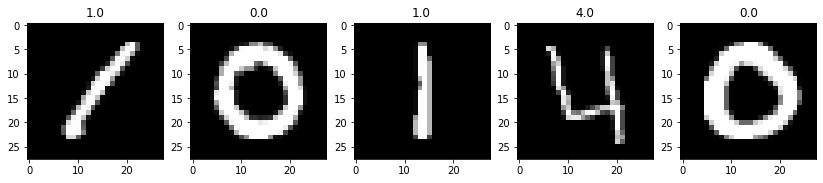

In [6]:
# Визуализируем исходные данные
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1])

In [7]:
# Вычисляем X и Y составляющие градиента с помощью оператора Собеля для тренировочной выборки
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [8]:
# Вычисляем X и Y составляющие градиента с помощью оператора Собеля для тестовой выборки
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [9]:
# Вычисляем угол и длину вектора градиента для тренировочной выборки
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [10]:
# Вычисляем угол и длину вектора градиента для тестовой выборки
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

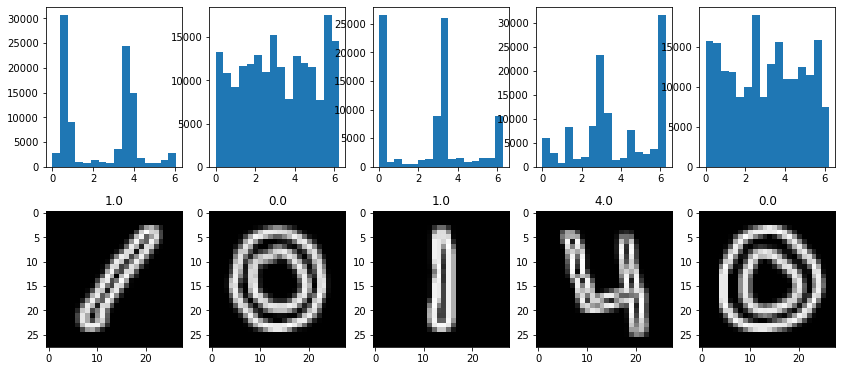

In [11]:
# Визуализируем результат
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

In [12]:
# Вычисляем гистограммы градиентов с учетом длины вектора градиента для тренировочной выборки
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [13]:
# Вычисляем гистограммы градиентов с учетом длины вектора градиента для тестовой выборки
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [14]:
# Нормируем вектор гистограммы для тренировочной выборки (используем L2 норму)
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [15]:
# Нормируем вектор гистограммы для тестовой выборки (используем L2 норму)
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [16]:
# Разделяем выборку на обучение и валидацию
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [17]:
# Вычисляем центроиды каждого из 10 классов
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

In [18]:
# Определяем ближайший центроид для валидации
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

In [19]:
# Оцениваем качество решения на валидационной выборке
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.4270238095238095


In [20]:
# Оцениваем качество решения на валидационной выборке
print(classification_report(y_val, pred_val))

              precision    recall  f1-score   support

         0.0       0.34      0.12      0.18       816
         1.0       0.59      0.76      0.66       909
         2.0       0.33      0.29      0.31       846
         3.0       0.55      0.49      0.51       937
         4.0       0.33      0.31      0.32       839
         5.0       0.46      0.67      0.55       702
         6.0       0.24      0.45      0.31       785
         7.0       0.73      0.41      0.53       893
         8.0       0.39      0.49      0.44       835
         9.0       0.48      0.27      0.34       838

    accuracy                           0.43      8400
   macro avg       0.44      0.43      0.42      8400
weighted avg       0.45      0.43      0.42      8400



In [21]:
# Оцениваем качество решения на валидационной выборке
print(confusion_matrix(y_val, pred_val))

[[102  24  82  30 106  18 221   7 179  47]
 [  0 692   2   0  44   1 139  17  13   1]
 [ 21   0 245 158  12 203  54  16 119  18]
 [ 14   0 113 456   3 235   7   2  98   9]
 [ 11 248   5   2 260   0 205  43  37  28]
 [  3   0  84  97   5 472   3   4  33   1]
 [ 53  26  66  11 116   4 355  13  76  65]
 [  4 113  38  16  66  41 189 368  15  43]
 [ 81   6  68  44  36  44 107   3 411  35]
 [ 11  73  31  20 149  11 222  30  65 226]]


In [22]:
# Осуществляем предсказание на тестовых данных
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

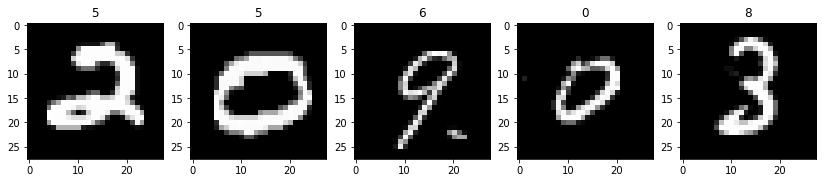

In [23]:
# Визуализируем предсказание
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1])

In [24]:
# Подготавливаем файл для отправки
with open('sample_submission.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

Получаем Score: 0.41628.   
Попробуем улучшить модель.

In [25]:
# Нормализуем данные с помощью метода главных компонент PCA
pca = PCA(n_components=30)
all_img = np.vstack([train_img.reshape(-1, 28 * 28), test_img.reshape(-1, 28 * 28)])
all_img_pca = pca.fit_transform(all_img)
train_img_pca = all_img[:train_img.shape[0], :]
test_img_pca = all_img[train_img.shape[0]:, :]

In [26]:
# Разделяем выборку на обучение и валидацию
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_img_pca, test_size=0.2,
    random_state=42)

In [27]:
# Используем алгоритм K-ближайших соседей
kNN = KNeighborsClassifier(n_neighbors=6, n_jobs=-1)
kNN.fit(x_train, y_train)
kNN_pred = kNN.predict(x_val)

In [28]:
# Оцениваем качество решения на валидационной выборке
print('Accuracy KNN: %s' % accuracy_score(y_val, kNN_pred))

Accuracy KNN: 0.9636904761904762


In [29]:
# Оцениваем качество решения на валидационной выборке
print(classification_report(y_val, kNN_pred))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       816
         1.0       0.93      1.00      0.96       909
         2.0       0.99      0.95      0.97       846
         3.0       0.96      0.96      0.96       937
         4.0       0.98      0.97      0.98       839
         5.0       0.95      0.96      0.95       702
         6.0       0.97      0.98      0.98       785
         7.0       0.95      0.96      0.96       893
         8.0       0.99      0.92      0.95       835
         9.0       0.95      0.94      0.95       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



In [30]:
# Оцениваем качество решения на валидационной выборке
print(confusion_matrix(y_val, kNN_pred))

[[812   0   0   0   0   0   4   0   0   0]
 [  0 906   0   0   0   0   3   0   0   0]
 [  7  13 802   3   1   1   1  17   1   0]
 [  3   4   5 898   0   9   1   5   6   6]
 [  1   6   0   0 815   0   3   1   0  13]
 [  0   3   0  14   0 672   7   0   2   4]
 [  8   2   0   0   0   4 771   0   0   0]
 [  0  20   3   0   1   0   0 859   0  10]
 [  1  14   2  15   3  21   3   1 770   5]
 [  3   3   1   9  11   2   0  18   1 790]]


In [31]:
# Осуществляем предсказание на тестовых данных
kNN_pred_test = kNN.predict(test_img_pca)

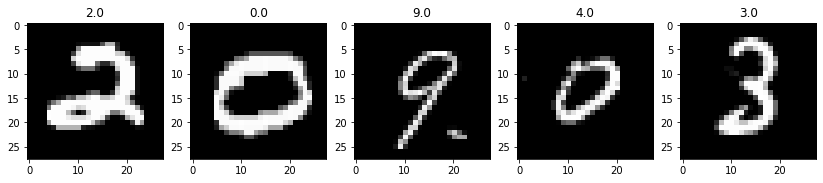

In [32]:
# Визуализируем предсказание
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % kNN_pred_test[i - 1])

In [33]:
# Подготавливаем файл для отправки
with open('sample_submission.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(kNN_pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

Получаем Score: 0.96357.
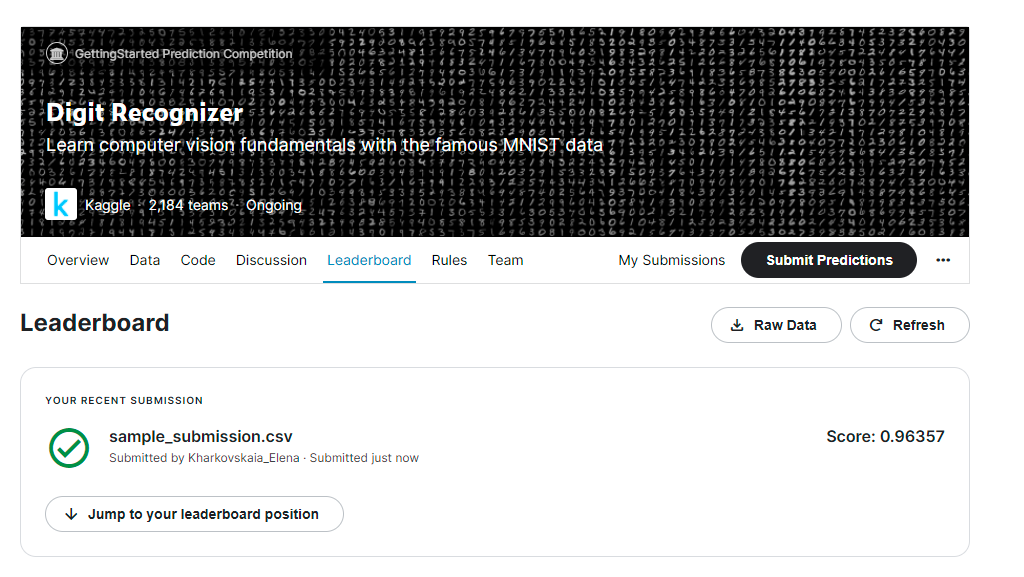   
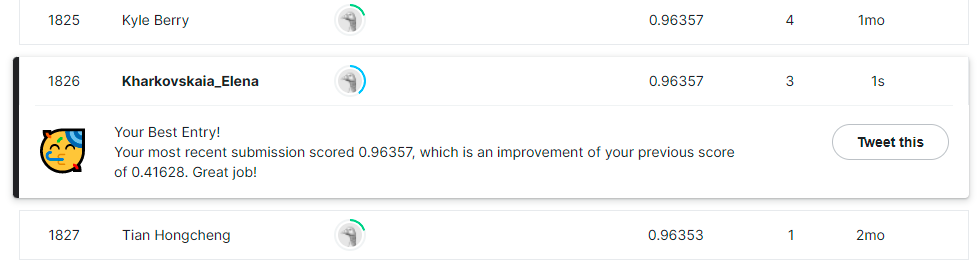